In [4]:
%matplotlib inline

In [5]:
from sklearn import linear_model
import matplotlib.pyplot as plt
import time
import Xlib.display as display
import gtk, pygtk
import csv
import numpy as np
import ConfigParser

In [6]:
theta = 3.5e-07

In [7]:
#read write project path
#TODO: configure this file according to your path: BehavioralAuthentication/src/main/php/configuration.cfg
config = ConfigParser.RawConfigParser()
config.read('configuration.cfg')

project_dir_path = config.get('Section1', 'project_dir')
resource_path = project_dir_path + "src/test/resources/"

In [8]:
window = gtk.Window()
screen = window.get_screen()

x_size = screen.get_width()
y_size = screen.get_height()

In [9]:
#ted dunning model

def extractFeatures(filename, n_last_timestamps_as_features = 200, normalize = True, bias = True):
    queue = {}
    
    diffTime = {}
    oldTime = -1.0
    
    maxX = 0.0
    
    x_width = float(screen.get_width()) 
    y_width = float(screen.get_height()) 

    i = 1
    with open(filename, 'r') as csvfile:
         spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
         for row in spamreader:
             if (len(row) == 3):
                    
                 timeV = float(row[0])
                
                 if (oldTime == -1):
                    oldTime = timeV
                 else:
                    diffTime[i] = timeV - oldTime
                    oldTime = timeV
                 
                 x = 0.0
                 y = 0.0
                
                 if (normalize):
                     x = float(row[1]) / x_width   
                     y = float(row[2]) / y_width
                 else:    
                     x = row[1]   
                     y = row[2] 

                 queue[i] = (timeV,x,y)  #by order (works only if input is sorted) - maybe by time??
                 i = i + 1


    featureIds = range(1, n_last_timestamps_as_features + 1)

    nFeatures = len(featureIds)*2 # times two because we have two dimensions x and y

    data = np.zeros((i - (max(featureIds)+ 1), nFeatures))
    
       
    target = np.zeros((i - (max(featureIds)+1), 2))

    for o in range(max(featureIds)+1,i):
        for u in range(0,len(featureIds)):
            data[o - max(featureIds) - 1,u*2 + 0] = queue[o - featureIds[u]][1]
            data[o - max(featureIds) - 1,u*2 + 1] = queue[o - featureIds[u]][2]

        target[o - max(featureIds) - 1,0] = queue[o][1]
        target[o - max(featureIds) - 1,1] = queue[o][2]

    
    
    print "mean difference in time step: " + str(np.mean(np.array(diffTime.values())))
    
    print("original shape: " + str(data.shape))
    
    if (bias):
        data = np.hstack((data, np.ones((data.shape[0], 1), dtype=data.dtype)))
        
    return ((data, target))

In [62]:
def generateModelData((data1,target1), n_last_timestamps_as_features = 200, 
                      v = False, build_all_model = True, p_train_general = 1.0, 
                      stddev_factor = 1.0, returnSmoothed = False):
    
    N_total = data1.shape[0]
    N_total_test = N_total * 0.4
    
    (data,target) = getMovementsOnly(data1, target1)
    N = data.shape[0]
    
    p_train = 0.6
    X_train = data[0:(N * p_train_general * p_train),:]
    y_train = target[0:(N * p_train_general * p_train),:]
    X_test1 = data[((N * p_train) + n_last_timestamps_as_features):N,:]
    y_test1 = target[((N * p_train) + n_last_timestamps_as_features):N,:]
    
    (X_test, y_test) = deleteNull(X_test1, y_test1)
    
    N_total_test = X_test.shape[0]
    

    regr = linear_model.LinearRegression(normalize=True)
    
    dist_train = getDistance(y_train)
    
    #impossible threshold
    impossible_threshold = np.array([stddev_factor, stddev_factor])


    # Train the model using the training sets
    regr.fit(X_train, y_train);
    
    #training error
    dist_train = getDistance(y_train)
    
    prediction_train = regr.predict(X_train)
    
    #target y is constrained to be within in [0,1]
    prediction_train[prediction_train < 0.0] = 0
    prediction_train[prediction_train > 1.0] = 1
    
    diff_train = np.abs(prediction_train - y_train)
    diff_x_train = diff_train[:,0]
    diff_y_train = diff_train[:,1]
    
    train_error_mse = (np.sum((np.power(diff_x_train, 2) + np.power(diff_y_train, 2))) / diff_x_train.shape[0])
    train_error_dist = (np.sum((np.power(diff_x_train, 2) + np.power(diff_y_train, 2))) / dist_train)
    
    (smoothed_time_error_train, smoothed_distance_error_train, N_smoothed_train) = \
    get_smoothed_result(X_train,y_train, diff_train, impossible_threshold, v = False) 
   

    #test error
    dist_test = getDistance(y_test)
    
    prediction_test = regr.predict(X_test)
    
    #target y is constrained to be within in [0,1]
    prediction_test[prediction_test < 0.0] = 0
    prediction_test[prediction_test > 1.0] = 1
    
    diff_test = np.abs(prediction_test - y_test)        
    diff_x_test = diff_test[:,0]
    diff_y_test = diff_test[:,1]
    
    test_error_mse = (np.sum(np.power(diff_x_test, 2) + np.power(diff_y_test, 2)) / diff_x_test.shape[0])
    test_error_dist = (np.sum(np.power(diff_x_test, 2) + np.power(diff_y_test, 2)) / dist_test)
    
    (smoothed_time_error_test, smoothed_distance_error_test, N_smoothed) = \
    get_smoothed_result(X_test,y_test, diff_test, impossible_threshold, v = v) 
    
    if (v):
        
        print("threshold: " + str(impossible_threshold))
           
        #Prediction of x-coordinate of the cursor over time
        plt.plot(y_test[:,0])
        plt.plot(prediction_test[:,0])
        plt.ylabel('relative postion - x coordinate of the cursor')
        plt.title("regression - x")
        plt.show()
        
        #Prediction of y-coordinate of the cursor over time
        plt.plot(y_test[:,1])
        plt.plot(prediction_test[:,1])
        plt.ylabel('relative postion - y coordinate of the cursor')
        plt.title("regression - y")
        plt.show()
        
        print("test - MSE: %.10f" % test_error_mse)
        print("test - MSE - dist: %.10f" % test_error_dist)
        
        print ("test - smoothed MSE: " + str(smoothed_time_error_test))
        print ("test - smoothed MSE per dist: " + str(smoothed_distance_error_test))
        
        #Test error over time
        threshold_line = np.ones(diff_x_test.shape) * impossible_threshold[0]        
        plt.plot(diff_x_test)
        plt.plot(threshold_line)
        plt.ylabel('Test error')
        plt.title("ErrorPerTestTime - x")
        plt.show()
        threshold_line = np.ones(diff_y_test.shape) * impossible_threshold[1]        
        plt.plot(diff_y_test)
        plt.plot(threshold_line)
        plt.ylabel('Test error')
        plt.title("ErrorPerTestTime - y")
        plt.show()
        
        #Training error over time
        threshold_line = np.ones(diff_x_train.shape) * impossible_threshold[0]
        plt.plot(diff_x_train)
        plt.plot(threshold_line)
        plt.ylabel('Training error')
        plt.title("ErrorPerTrainTime - x")
        plt.show()
        
        threshold_line = np.ones(diff_y_train.shape) * impossible_threshold[1]
        plt.plot(diff_y_train)
        plt.plot(threshold_line)
        plt.ylabel('Training error')
        plt.title("ErrorPerTrainTime - y")
        plt.show()
        
        print("train - MSE: %.10f" % train_error_mse)
        print("train - MSE - dist: %.10f" % train_error_dist)    
        
        print ("train - smoothed MSE: " + str(smoothed_time_error_train))
        print ("train - smoothed MSE per dist: " + str(smoothed_distance_error_train))
    
        
    if (returnSmoothed):
        return((smoothed_time_error_test, smoothed_distance_error_test, float(N_smoothed) / float(N_total_test)))
    
    if (build_all_model):   
        final_regr = linear_model.LinearRegression(normalize=True)
    
        final_regr.fit(data, target);
    
        return ((final_regr, impossible_threshold))
        #return (regr, two_sigma)
    else:
        return test_error_mse

In [11]:
def generateModel(dataFile, n_last_timestamps_as_features = 200, v = False, stddev_factor = 0.0):
    (data,target) = extractFeatures(dataFile, n_last_timestamps_as_features)
    
    return generateModelData((data,target), n_last_timestamps_as_features = n_last_timestamps_as_features, 
                             v = v, stddev_factor = stddev_factor)

In [91]:
def deleteNull(data, target):
    limit = 10
    
    dataCP = np.asmatrix(np.copy(data))
    targetCP = np.asmatrix(np.copy(target))
    
    N = data.shape[0]
    
    to_be_deleted = np.zeros((N,1))
    
    
    indices = {}    
    i = 0
    count = 0
    current = np.zeros((2,1))
    
    while True: #do
        if (current[0,0] == targetCP[i,0] and current[0,1] == targetCP[i,1]):
            count += 1
            indices[count] = i
        else:
            count = 0
            indices = {}
            current = targetCP[i,:]
                
        if (count >= limit):
            to_be_deleted[indices.values()] = 1
            count = 0
            indices = {}
            current = targetCP[i,:]
         
        i += 1
        
        if (i >= N):
            break
            
    b = np.array(to_be_deleted == 0)
    
    retData1 = dataCP[b.view(np.ndarray).ravel()==True, :]
    retTarget1 = targetCP[b.view(np.ndarray).ravel()==True, :]
    
    #print (dataCP.shape)
    #print (retData1.shape)
    
    return ((np.matrix(retData1), np.matrix(retTarget1)))       

In [13]:
def getMovementsOnly(data, target):
    moveOnlyData = []
    moveOnlyTarget = []
    
    first = True
    
    featuresize = data.shape[1]
    
    if (data.shape[1] % 1 == 1): # if bias term included
        featuresize -= 1
    featuresize /= 2
    
    if (featuresize > 1):
    
        for l in range(data.shape[0]):
            fcounter = 0
            for f in [0,1]:
                ccounter = 0
                for c in range(featuresize):
                    if (data[l][c*2 + f] == data[l][f]):
                        ccounter += 1
                if (ccounter == featuresize):
                    fcounter += 1

            if (fcounter < 2): #something is different
                if (first):
                    moveOnlyData = [data[l]]
                    moveOnlyTarget = [target[l]]
                    first = False
                else:
                    moveOnlyData = np.concatenate((moveOnlyData, [data[l]]), axis=0)
                    moveOnlyTarget = np.concatenate((moveOnlyTarget, [target[l]]), axis=0)

        return (np.matrix(moveOnlyData), np.matrix(moveOnlyTarget))
    else:
        return ((np.matrix(data), np.matrix(target)))
            

In [14]:
def euclidean (p1, p2):
    return np.sqrt(np.sum(np.power(p1 - p2, 2)))

def getDistance(target):
    distance = 0.0
    for t in np.arange(1, target.shape[0], 1):
        distance += euclidean(target[t,:], target[(t-1),:])
    
    return distance    

def getSmoothedDistance(target, isOverThreshold):
    
    distance = 0.0
    for t in np.arange(1, target.shape[0], 1):
        last_point_x = target[t-1,0]
        last_point_y = target[t-1,1]
        if (isOverThreshold[t] == False):
            distance += euclidean(target[t,:], np.array([last_point_x,last_point_y])) 
    
    return distance

In [15]:
def get_smoothed_result(newData, newTarget, diff, threshold, v = False):
    
    diff_smoothed = np.copy(diff)
    
    N_smoothed = newTarget.shape[0]
    
    is_over_threshold = np.logical_or((diff_smoothed[:,0] > threshold[0]),(diff_smoothed[:,1] > threshold[1]))
    
    newdist = getSmoothedDistance(newTarget, is_over_threshold)
    
    for l in range(diff_smoothed.shape[0]):
        if (is_over_threshold[l]):
            diff_smoothed[l,0] = 0
            diff_smoothed[l,1] = 0
            N_smoothed -= 1
            
    if (v):
        plt.plot(diff_smoothed[:,0])
        plt.ylabel('prediction x error -smoothed')
        plt.show()

        plt.plot(diff_smoothed[:,1])
        plt.ylabel('prediction y error -smoothed')
        plt.show()
    
    time_error = 0.0
    if (N_smoothed > 0.0):
        time_error = np.sum(np.power(diff_smoothed,2)) / N_smoothed
    
    distance_error = 0.0
    if (newdist > 0.0):
        distance_error = np.sum(np.power(diff_smoothed,2)) / newdist
    
    return ((time_error,distance_error, N_smoothed))

In [16]:
def showStats(file, m, threshold, n_last_timestamps_as_features = 200, normalize = True, v = True):
    (fileX1, fileY1) = extractFeatures(file, 
                                     n_last_timestamps_as_features = n_last_timestamps_as_features, 
                                     normalize = normalize) 
    
    return showStatsData((fileX1, fileY1), m, threshold, n_last_timestamps_as_features = n_last_timestamps_as_features, v = v)

In [64]:
def showStatsData((fileX, fileY), m, threshold, n_last_timestamps_as_features = 200, v = True):
    
    #(newData, newTarget) = getMovementsOnly(fileX, fileY)   
    (newData, newTarget) = deleteNull(fileX, fileY)
    
    if newData.shape[0] <= 1: return(0.0, 0.0, 0, 1)
    
    #distance
    dist = getDistance(newTarget)
    
    prediction_sample = m.predict(newData)
    
    #target y is constrained to be within in [0,1]
    prediction_sample[prediction_sample < 0.0] = 0
    prediction_sample[prediction_sample > 1.0] = 1

    ErrorPerTestTime = np.sum(np.absolute(prediction_sample - newTarget),1);
    
    threshold_line = np.ones(ErrorPerTestTime.shape) * (threshold[0] + threshold[1])
    
    if (v):
        #error of sample
        plt.plot(ErrorPerTestTime)
        plt.plot(threshold_line)
        plt.ylabel('prediction error')
        plt.show()

        #Prediction of x-coordinate of the cursor over time
        plt.plot(prediction_sample[:,0])
        plt.plot(newData[:,0])
        plt.ylabel('relative x-coordinate')
        plt.title("Regression for x-coordinate")    
        plt.show()

        #Prediction of y-coordinate of the cursor over time
        plt.plot(prediction_sample[:,1])
        plt.plot(newData[:,1])
        plt.ylabel('relative y-coordinate')
        plt.title("Regression for y-coordinate")
        plt.show()

    diff = np.absolute(prediction_sample - newTarget)
    
    N = newTarget.shape[0]
    
    if (v):
        print ("MSE per 0.03s: " + str(np.sum(np.power(diff,2)) / N))
        print ("MSE per pixel move: " + str(np.sum(np.power(diff,2)) / dist))
        print ("number of records: " + str(N))

        print ("\nmax - |x+y|: " + str(np.max(diff)))
        print ("max - squared: " + str(np.max(np.power(diff,2))))
    
    (time_error, distance_error, N_smoothed) = get_smoothed_result(newData, newTarget, diff, threshold)    
    
    if (v):
        print ("smoothed MSE: " + str(time_error))
        print ("smoothed MSE per dist: " + str(distance_error))
    
    if (time_error > theta): 
        if (v):
            print ("This is not Felix - You are unauthorized!")
        return (time_error, distance_error, N_smoothed, 0)
    else:
        if (v):
            print ("This is Felix - Welcome to this awesome computer!")  
        return (time_error, distance_error, N_smoothed, 1)

mean difference in time step: 0.0300000000143
original shape: (1900, 200)
0.323125
(803, 1)
(803, 201)
504.0
(299, 201)
0.14
(436, 1)
(436, 201)
292.0
(144, 201)


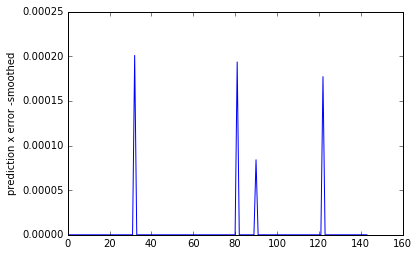

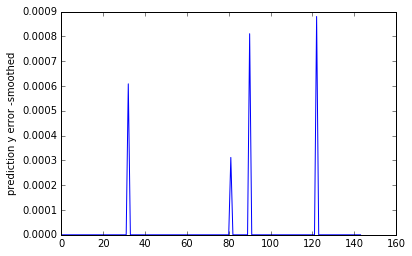

threshold: [ 0.001  0.001]


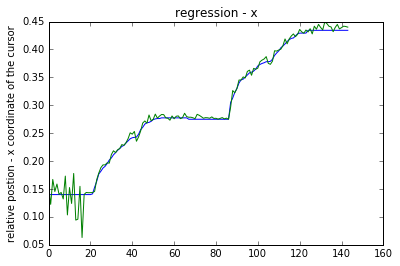

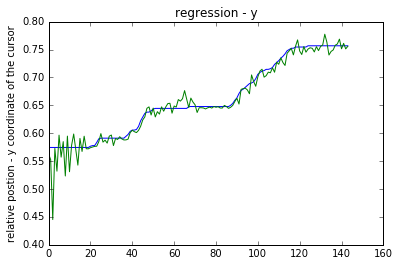

test - MSE: 0.0003866011
test - MSE - dist: 0.1490315421
test - smoothed MSE: 5.04165582845e-07
test - smoothed MSE per dist: 0.000168949278454


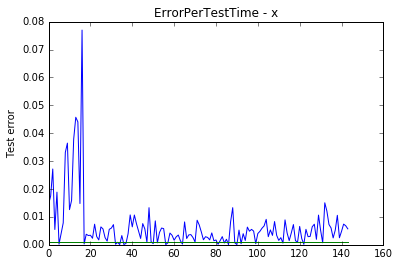

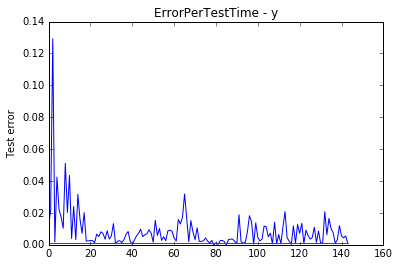

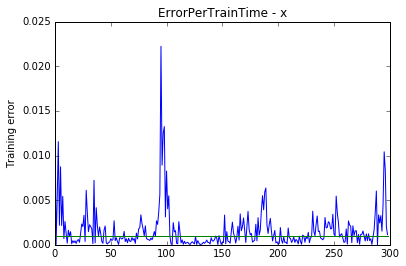

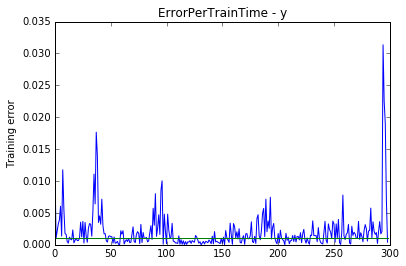

train - MSE: 0.0000235605
train - MSE - dist: 0.0037996100
train - smoothed MSE: 4.65245108289e-07
train - smoothed MSE per dist: 0.000112655000402


In [63]:
current_number_features = 100

(model_small,two_sigma_small) = generateModel(resource_path + "unauthorized/martin_60sec",
                                  n_last_timestamps_as_features=current_number_features, v = True,
                                  stddev_factor = 0.001)

mean difference in time step: 0.03000475079
original shape: (119881, 200)


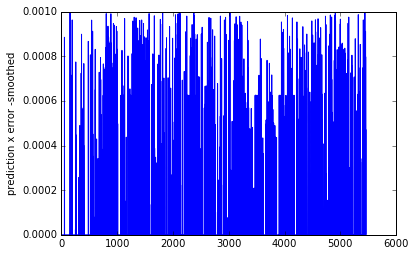

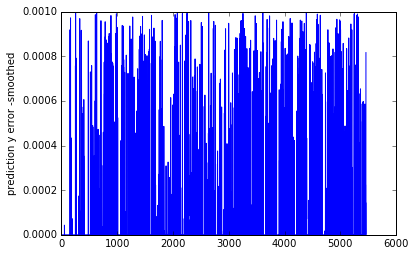

threshold: [ 0.001  0.001]


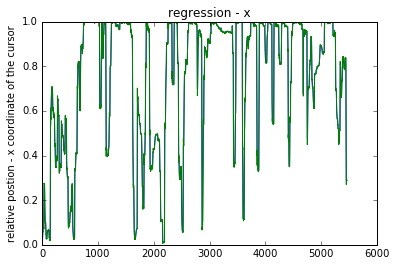

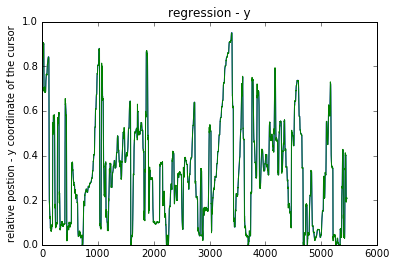

test - MSE: 0.0001773867
test - MSE - dist: 0.0181463049
test - smoothed MSE: 6.51029049115e-07
test - smoothed MSE per dist: 0.000535620855685


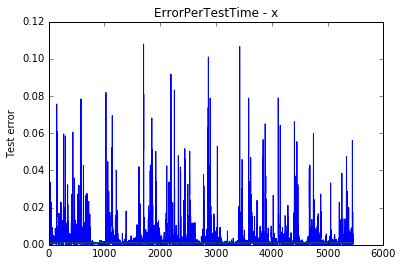

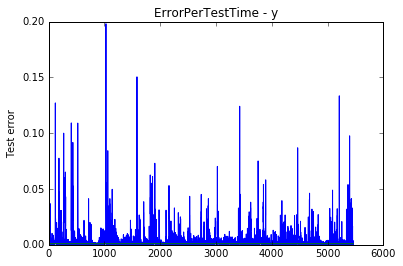

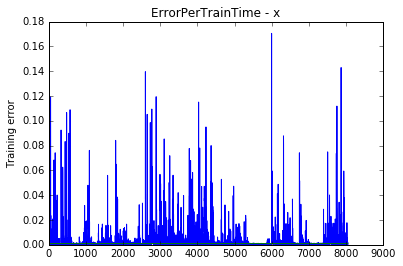

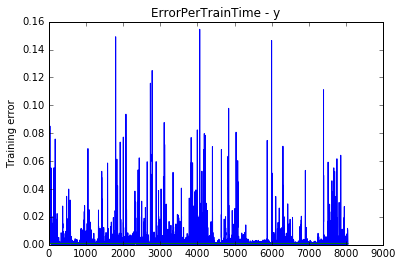

train - MSE: 0.0001783608
train - MSE - dist: 0.0213288454
train - smoothed MSE: 7.02228917384e-07
train - smoothed MSE per dist: 0.000728553512887


In [71]:
current_number_features = 100

(model,two_sigma) = generateModel(resource_path + "felix/felix_1h",
                                  n_last_timestamps_as_features=current_number_features, v = True,
                                  stddev_factor = 0.001)

Authorized user - test
mean difference in time step: 0.030002375188
original shape: (239882, 200)


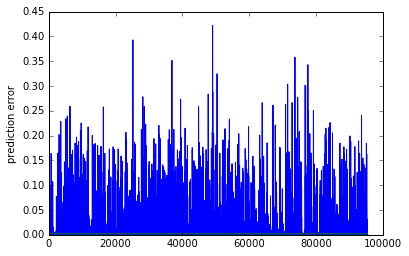

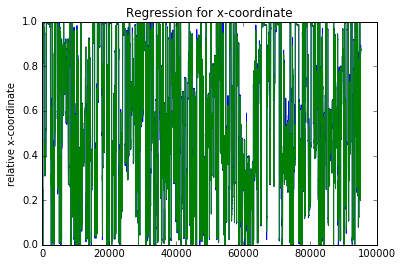

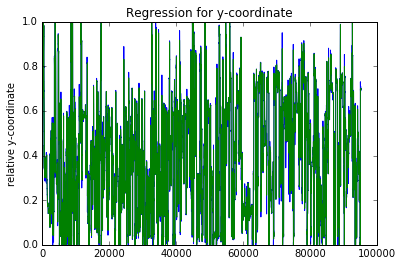

MSE per 0.03s: 0.000161758649086
MSE per pixel move: 0.0298823856473
number of records: 95309

max - |x+y|: 0.236920892183
max - squared: 0.056131509153
smoothed MSE: 4.02118566745e-07
smoothed MSE per dist: 0.160472840369
This is not Felix - You are unauthorized!


In [386]:
print ("Authorized user - test")
showStats(resource_path + "felix/felix_2h", model, two_sigma, n_last_timestamps_as_features=current_number_features)

In [ ]:
#impact of number of features on accuracy

mseT = {}

endFeatures = 100

for i in np.arange(1,endFeatures,1):
    (fileX1, fileY1) = extractFeatures(resource_path + "felix/felix_1h", 
                                     n_last_timestamps_as_features = i, 
                                     normalize = True) 
    
    mseT[i] = generateModelData((fileX1, fileY1),n_last_timestamps_as_features = i, v = False, 
                                build_all_model = False)
    print mseT[i]
    
plt.plot(range(1, endFeatures), np.array(mseT.values(), dtype=float))
plt.ylabel('mean squared error')
plt.xlabel('number of features')
plt.show()

mean difference in time step: 0.03000475079
0.000107080753437
9.37452859732e-05
8.71437238137e-05
8.56322061918e-05
8.37051035438e-05
8.29384014329e-05
8.25208500063e-05
8.21742820317e-05
8.19850493831e-05
8.15633464322e-05


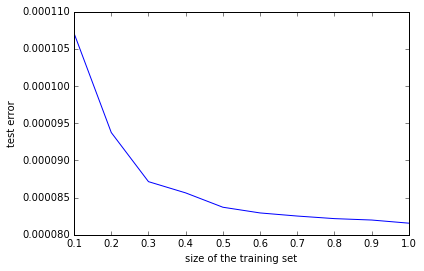

In [47]:
#impact of training size on accuracy

(fileX1, fileY1) = extractFeatures(resource_path + "felix/felix_1h", 
                                     n_last_timestamps_as_features = current_number_features, 
                                     normalize = True) 

mseT = {}

r = np.arange(1,11,1)

for i in r:
    mseT[i] = generateModelData((fileX1, fileY1), n_last_timestamps_as_features = current_number_features,
                                v = False, build_all_model = False, p_train_general = i * 0.1)
    print mseT[i]
    
plt.plot(r * 0.1, np.array(mseT.values(), dtype=float))
plt.ylabel('test error')
plt.xlabel('size of the training set')
plt.show()

mean difference in time step: 0.03000475079
3.41967648207e-07: 0.423893025863
8.7423486813e-07: 0.24541596605
1.47522476977e-06: 0.16758747698
2.03749480149e-06: 0.128433021059
2.61171313583e-06: 0.104652093843
3.20427580108e-06: 0.0875170149732
3.7875279345e-06: 0.0758267275202
4.2948606e-06: 0.0677396108576
4.84484063653e-06: 0.061414044359
5.42665496326e-06: 0.0558891824806
6.04555943595e-06: 0.0512450956842
6.6888578037e-06: 0.0470814316599
7.38281762974e-06: 0.0431579790215
8.07790657548e-06: 0.0399551605413
8.65064705127e-06: 0.0377131876051
9.41210731431e-06: 0.0349907918969
1.02058510918e-05: 0.0326687484987
1.1049012392e-05: 0.0303467051005
1.15653693334e-05: 0.0289855072464
1.24692458718e-05: 0.0270638161582
MSE


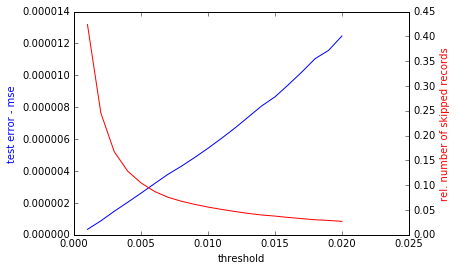

In [249]:
#smoothing effect on accuracy

(fileX1, fileY1) = extractFeatures(resource_path + "felix/felix_1h",  #"felix/felix_10sec_2" 
                                     n_last_timestamps_as_features = current_number_features, 
                                     normalize = True) 


error_time = {}
error_dist = {}
n_skipped = {}

r = np.arange(1,21,1)

step_size = 0.001

for i in r:
    (error_time[i], error_dist[i], n_smoothed) = generateModelData((fileX1, fileY1), 
                                                       n_last_timestamps_as_features = current_number_features, 
                                                       v = False, build_all_model = False, stddev_factor = i * step_size,
                                                       returnSmoothed = True)
    n_skipped[i] = 1.0 - n_smoothed
    print (str(error_time[i]) + ": " + str(n_skipped[i]))
    
print("MSE")
fig, ax1 = plt.subplots()   
ax1.plot(r * step_size, np.array(error_time.values(), dtype=float), color='b')
ax1.set_xlabel('threshold')
ax1.set_ylabel('test error - mse', color='b')

ax2 = ax1.twinx() 
ax2.plot(r * step_size, np.array(n_skipped.values(), dtype=float), color = 'r')
ax2.set_ylabel('rel. number of skipped records', color = 'r')
plt.show()



mean difference in time step: 0.0300000000286
original shape: (234, 200)
Emely test1


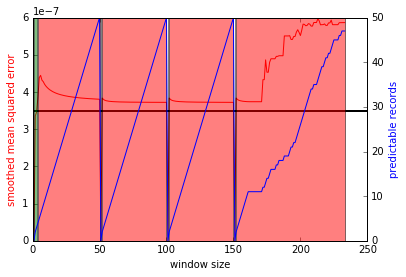

mean difference in time step: 0.0300000000286
original shape: (234, 200)
Felix test5


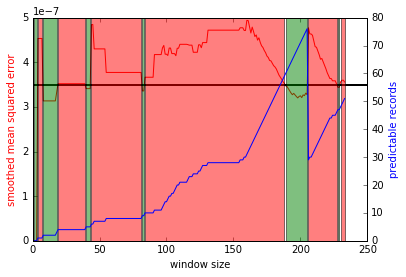

mean difference in time step: 0.0300000000286
original shape: (234, 200)
Felix test4


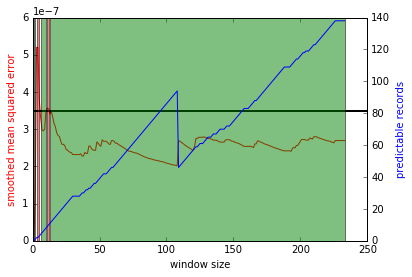

mean difference in time step: 0.0300000000286
original shape: (234, 200)
Niklas test1


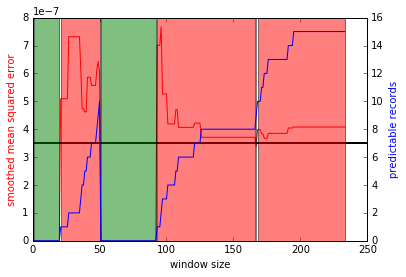

mean difference in time step: 0.0300000000286
original shape: (234, 200)
Felix test1


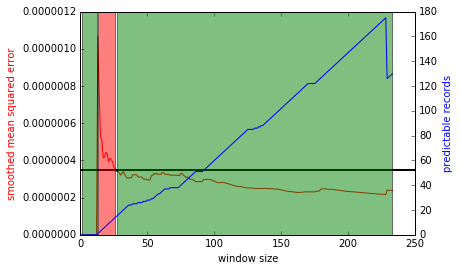

mean difference in time step: 0.03003003003
original shape: (234, 200)
Felix test2


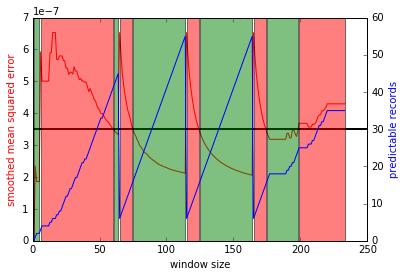

mean difference in time step: 0.0300000000286
original shape: (234, 200)
Felix test3 - lying in bed


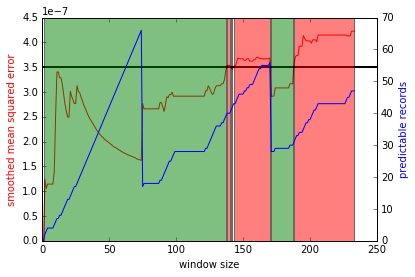

mean difference in time step: 0.0300000000143
original shape: (1900, 200)
Martin test1


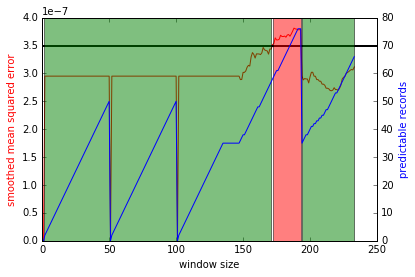

mean difference in time step: 0.0300000000286
original shape: (234, 200)
Elias test1


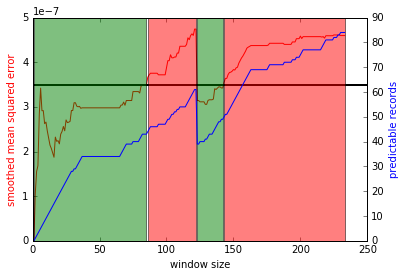

In [90]:
#time window impact on classification

file_names = {}
file_names["Felix test1"] = resource_path + "felix/felix_10sec_1"
file_names["Felix test2"] = resource_path + "felix/felix_10sec_2"
file_names["Felix test3 - lying in bed"] = resource_path + "felix/felix_10sec_3"
file_names["Felix test4"] = resource_path + "felix/felix_10sec_4"
file_names["Felix test5"] = resource_path + "felix/felix_10sec_5"

file_names["Niklas test1"] = resource_path + "unauthorized/niklas_10sec"
file_names["Elias test1"] = resource_path + "unauthorized/elias_10sec"
file_names["Emely test1"] = resource_path + "unauthorized/emely_10sec"
file_names["Martin test1"] = resource_path + "unauthorized/martin_60sec"

test_size = 234

for test_title, f_name in file_names.iteritems():
    

    (fileX1, fileY1) = extractFeatures(f_name,
                                         n_last_timestamps_as_features = current_number_features, 
                                         normalize = True) 


    error_time = {}
    error_dist = {}
    n_skipped = {}
    
    classification_acc = np.zeros((test_size,1))
    classifyable_n = np.zeros((test_size,1))

    r = np.arange(1,test_size,1)

    for i in r:
        (error_time[i], distance_error, classifyable_n[i], classification_acc[i]) = showStatsData((fileX1[0:i,:], fileY1[0:i,:]), model, two_sigma, n_last_timestamps_as_features = current_number_features, v = False)  
    
    
    print(test_title)
    
    # show how to use transforms to create axes spans where a certain condition is satisfied
    fig, ax = plt.subplots()
    x = r
    y = np.matrix(error_time.values()).A1
    ax.plot(x, y, color = 'r')
    
    # use the data coordinates for the x-axis and the axes coordinates for the y-axis
    import matplotlib.transforms as mtransforms
    trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
    
    
    ax.set_xlabel('window size')
    ax.set_ylabel('smoothed mean squared error', color = 'r')
    
    
    ax2 = ax.twinx() 
    ax2.fill_between(x, 0.0, 1.0, where=y <= theta, facecolor='green', alpha=0.5, transform=trans)
    ax2.fill_between(x, 0.0, 1.0, where=y > theta, facecolor='red', alpha=0.5, transform=trans)
    
    ax.axhline(theta, color='black', lw=2, alpha=1.0)
    
    ax2.set_ylabel('predictable records', color = 'b')
    ax2.plot(classifyable_n, color='b')
    
    plt.show()


Coefficients:


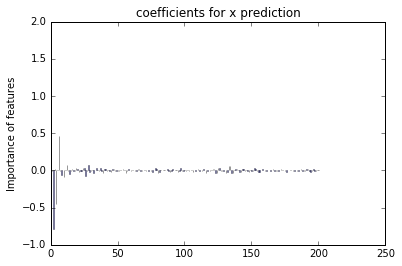

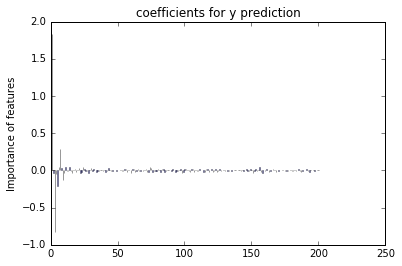

In [456]:
koef = np.asmatrix(model.coef_).A1

print('Coefficients:')

index = np.arange((len(koef)/2))
bar_width = 0.35

opacity = 0.4
error_config = {'ecolor': '0.3'}

plt.bar(index, koef[0:(len(koef)/2)], bar_width, alpha=opacity, color='b')
plt.title('coefficients for x prediction')
plt.ylabel("Importance of features")
plt.show()

plt.bar(index, koef[(len(koef)/2):len(koef)], bar_width, alpha=opacity, color='b')
plt.title('coefficients for y prediction')
plt.ylabel("Importance of features")
plt.show()


Felix test1
mean difference in time step: 0.0300000000286
original shape: (234, 200)


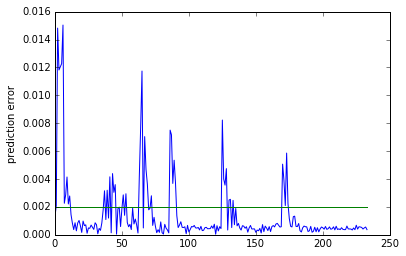

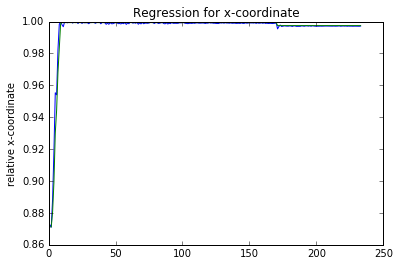

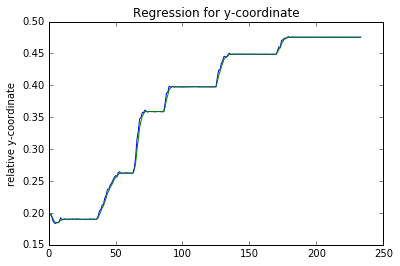

MSE per 0.03s: 6.16281270351e-06
MSE per pixel move: 0.0034550479332
number of records: 234

max - |x+y|: 0.0140761367078
max - squared: 0.000198137624617
smoothed MSE: 2.14566434299e-07
smoothed MSE per dist: 0.000728184836404
This is Felix - Welcome to this awesome computer!


(2.1456643429949254e-07, 0.00072818483640390273, 181, 1)

In [531]:
print ("Felix test1")
showStats(resource_path + "felix/felix_10sec_1",model, two_sigma, 
          n_last_timestamps_as_features=current_number_features)

Felix test2
mean difference in time step: 0.03003003003
original shape: (234, 200)


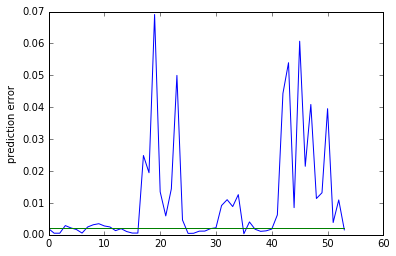

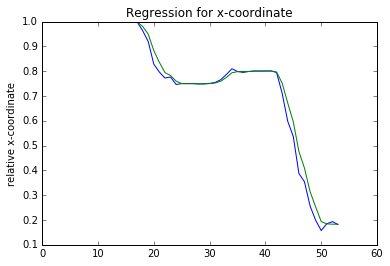

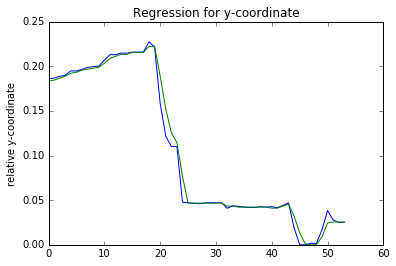

MSE per 0.03s: 0.000285300413408
MSE per pixel move: 0.0148690092105
number of records: 54

max - |x+y|: 0.0596023484721
max - squared: 0.00355243994339
smoothed MSE: 4.85869768448e-07
smoothed MSE per dist: 0.000479585813866
This is not Felix - You are unauthorized!


(4.8586976844810298e-07, 0.00047958581386627725, 14, 0)

In [93]:
print ("Felix test2")
showStats(resource_path + "felix/felix_10sec_2",model, two_sigma, n_last_timestamps_as_features=current_number_features)

Felix test3 - lying in bed
mean difference in time step: 0.0300000000286
original shape: (234, 200)


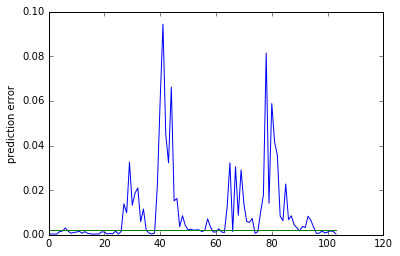

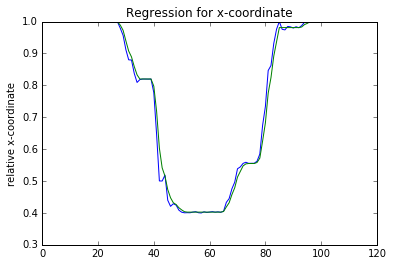

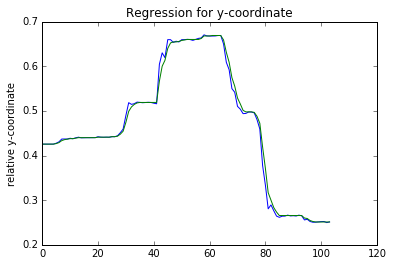

MSE per 0.03s: 0.000240042523387
MSE per pixel move: 0.0173749240742
number of records: 104

max - |x+y|: 0.0585860986895
max - squared: 0.00343233095965
smoothed MSE: 3.34409126229e-07
smoothed MSE per dist: 0.00124686831351
This is Felix - Welcome to this awesome computer!


(3.3440912622903797e-07, 0.0012468683135111282, 29, 1)

In [94]:
print ("Felix test3 - lying in bed")
showStats(resource_path + "felix/felix_10sec_3",model, two_sigma, n_last_timestamps_as_features=current_number_features)

Felix test4
mean difference in time step: 0.0300000000286
original shape: (234, 200)


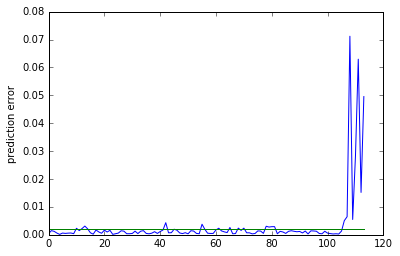

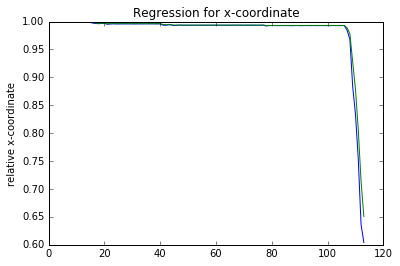

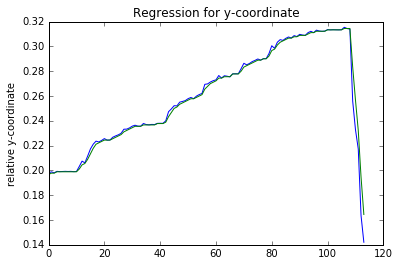

MSE per 0.03s: 6.41885943441e-05
MSE per pixel move: 0.0125086271042
number of records: 114

max - |x+y|: 0.0405277664897
max - squared: 0.00164249985664
smoothed MSE: 3.63813340766e-07
smoothed MSE per dist: 0.000465151023644
This is not Felix - You are unauthorized!


(3.6381334076642142e-07, 0.00046515102364366962, 71, 0)

In [95]:
print ("Felix test4")
showStats(resource_path + "felix/felix_10sec_4",model, two_sigma, n_last_timestamps_as_features=current_number_features)

Felix test5
mean difference in time step: 0.0300000000286
original shape: (234, 200)


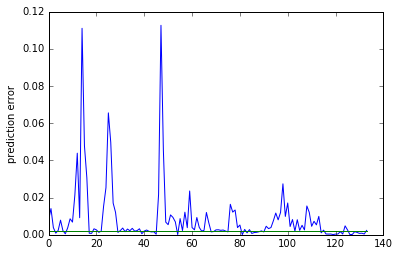

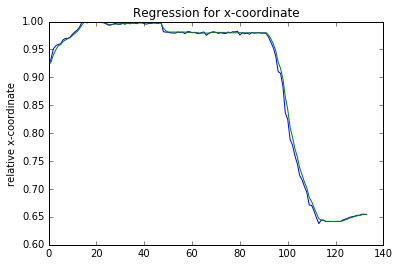

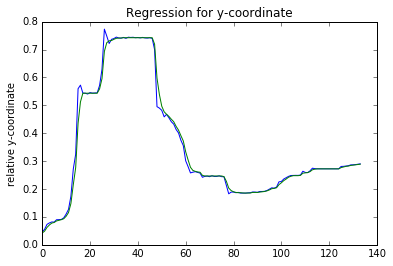

MSE per 0.03s: 0.000310566295205
MSE per pixel move: 0.0251753560696
number of records: 134

max - |x+y|: 0.110826472995
max - squared: 0.0122825071165
smoothed MSE: 3.38807487412e-07
smoothed MSE per dist: 0.000245751443798
This is Felix - Welcome to this awesome computer!


(3.3880748741227586e-07, 0.00024575144379765742, 27, 1)

In [97]:
print ("Felix test5")
showStats(resource_path + "felix/felix_10sec_5",model, two_sigma, n_last_timestamps_as_features=current_number_features)

Niklas test1
mean difference in time step: 0.0300000000286
original shape: (234, 200)


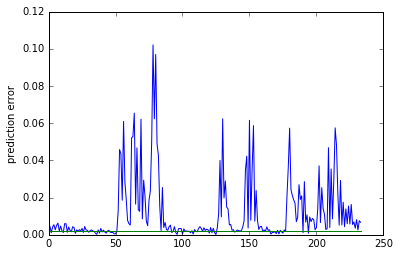

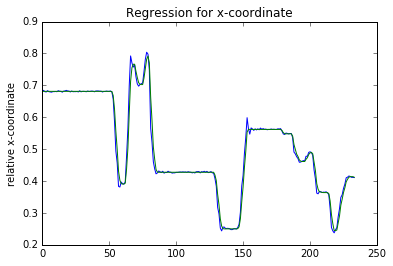

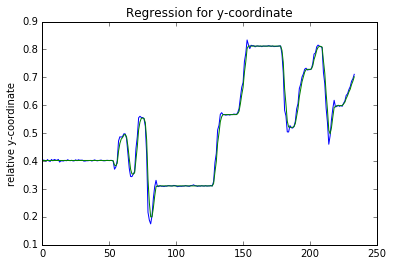

MSE per 0.03s: 0.000296348875549
MSE per pixel move: 0.0179435617065
number of records: 234

max - |x+y|: 0.0900139371297
max - squared: 0.00810250887759
smoothed MSE: 4.76762283176e-07
smoothed MSE per dist: 0.000286277338255
This is not Felix - You are unauthorized!


(4.7676228317573701e-07, 0.00028627733825501133, 26, 0)

In [536]:
print ("Niklas test1")
showStats(resource_path + "unauthorized/niklas_10sec",model, two_sigma, n_last_timestamps_as_features=current_number_features)

Elias test1
mean difference in time step: 0.0300000000286
original shape: (234, 200)


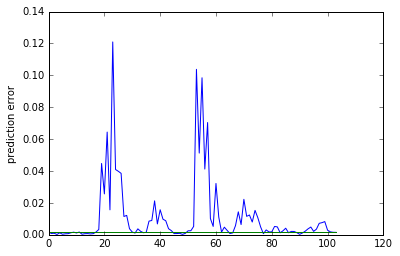

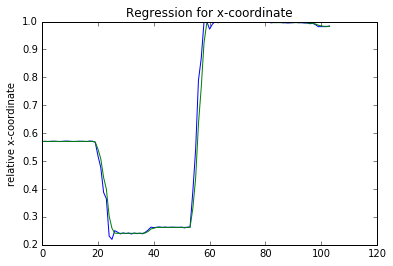

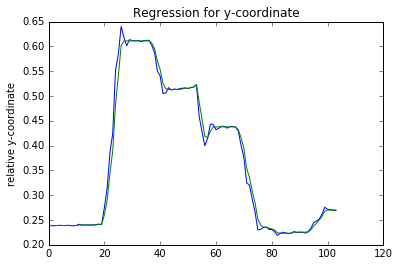

MSE per 0.03s: 0.000361061990139
MSE per pixel move: 0.0228681876111
number of records: 104

max - |x+y|: 0.0891744752982
max - squared: 0.00795208704471
smoothed MSE: 4.63608180441e-07
smoothed MSE per dist: 0.00375522626157
This is not Felix - You are unauthorized!


(4.6360818044077696e-07, 0.0037552262615703005, 27, 0)

In [98]:
print ("Elias test1")
showStats(resource_path + "unauthorized/elias_10sec",model, two_sigma, n_last_timestamps_as_features=current_number_features)

Emely
mean difference in time step: 0.0300000000286
original shape: (234, 200)


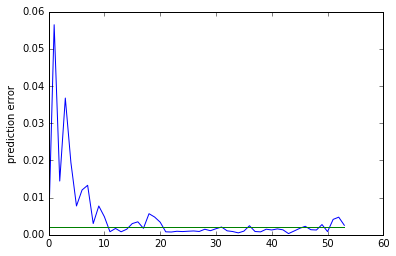

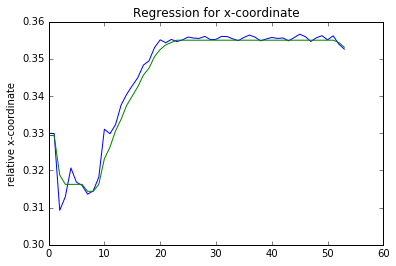

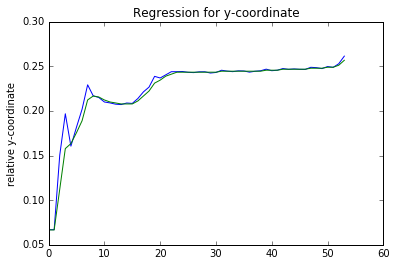

MSE per 0.03s: 7.72005947333e-05
MSE per pixel move: 0.0178267164505
number of records: 54

max - |x+y|: 0.0452930088061
max - squared: 0.00205145664671
smoothed MSE: 6.09662284815e-07
smoothed MSE per dist: 0.000736925975778
This is not Felix - You are unauthorized!


(6.0966228481540553e-07, 0.00073692597577761836, 24, 0)

In [99]:
print ("Emely")
showStats(resource_path + "unauthorized/emely_10sec", model, two_sigma, n_last_timestamps_as_features=current_number_features)

Martin
mean difference in time step: 0.0300000000143
original shape: (1900, 200)


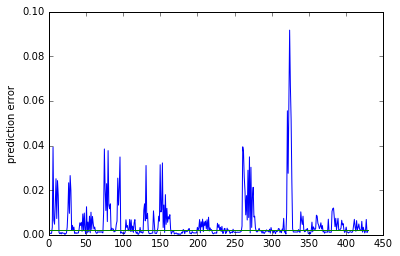

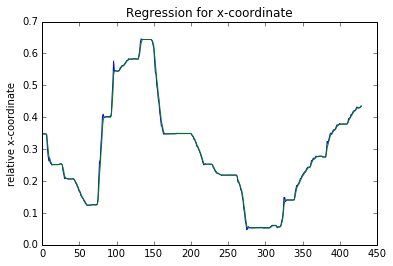

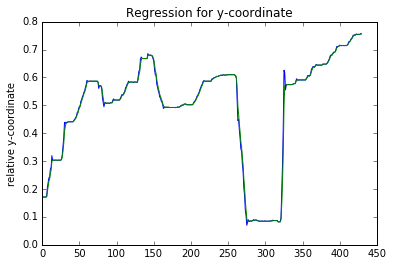

MSE per 0.03s: 8.34038305701e-05
MSE per pixel move: 0.0114445783537
number of records: 430

max - |x+y|: 0.0755707077056
max - squared: 0.00571093186312
smoothed MSE: 5.4004572261e-07
smoothed MSE per dist: 0.000592245391623
This is not Felix - You are unauthorized!


(5.40045722610026e-07, 0.00059224539162263453, 171, 0)

In [92]:
print ("Martin")
showStats(resource_path + "unauthorized/martin_60sec", model, two_sigma, n_last_timestamps_as_features=current_number_features)

In [441]:
#mouse didn't move at all
print ("mouse didn't move at all")
showStats(resource_path + "felix/nothing_10sec", model, two_sigma, n_last_timestamps_as_features=current_number_features)

mouse didn't move at all
mean difference in time step: 0.0300000000286
original shape: (234, 200)


In [476]:
test_size = 234

mean difference in time step: 0.0300000000143
original shape: (1900, 200)


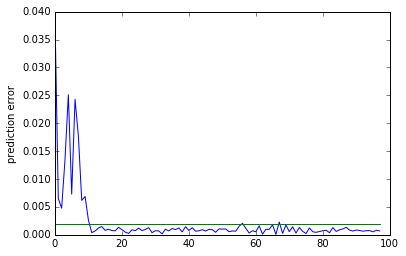

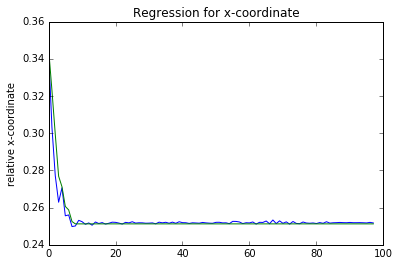

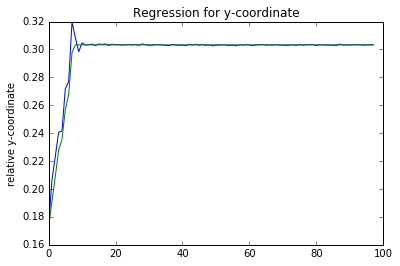

MSE per 0.03s: 2.13479020549e-05
MSE per pixel move: 0.014955950621
number of records: 98

max - |x+y|: 0.0213553113569
max - squared: 0.00045604932315
smoothed MSE: 3.96420535119e-07
smoothed MSE per dist: 0.0
This is not Felix - You are unauthorized!


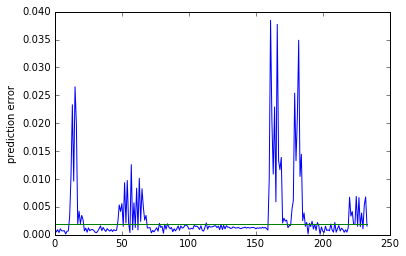

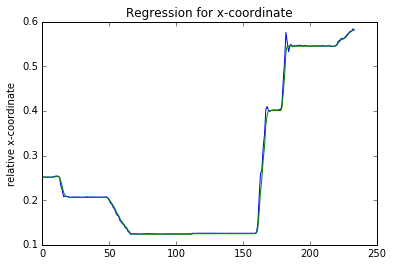

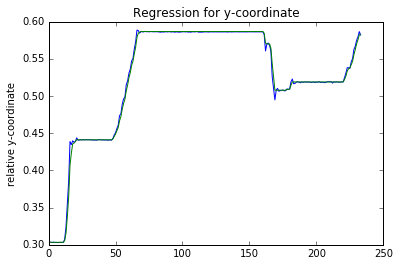

MSE per 0.03s: 3.11499627516e-05
MSE per pixel move: 0.00866990690156
number of records: 234

max - |x+y|: 0.0308989323202
max - squared: 0.00095474401853
smoothed MSE: 6.36437479083e-07
smoothed MSE per dist: 0.00196107609163
This is not Felix - You are unauthorized!


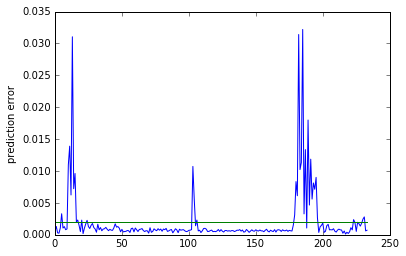

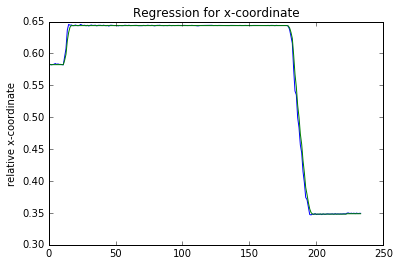

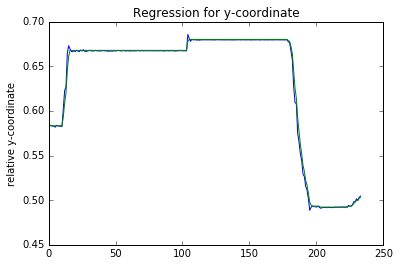

MSE per 0.03s: 1.20881607621e-05
MSE per pixel move: 0.00581843640913
number of records: 234

max - |x+y|: 0.0185791114057
max - squared: 0.000345183380626
smoothed MSE: 3.58005894339e-07
smoothed MSE per dist: 0.00264723345329
This is not Felix - You are unauthorized!


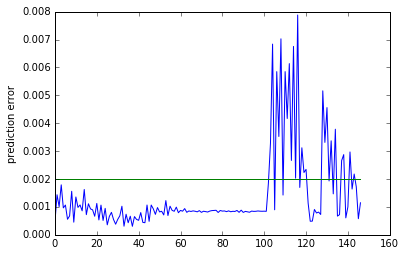

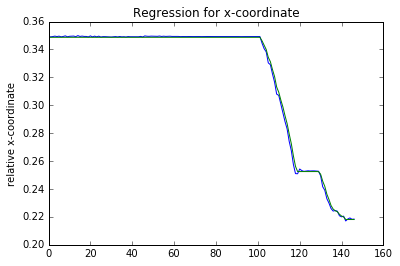

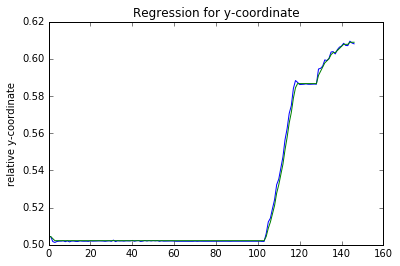

MSE per 0.03s: 2.31720905168e-06
MSE per pixel move: 0.00192055033817
number of records: 147

max - |x+y|: 0.00476832468218
max - squared: 2.27369202747e-05
smoothed MSE: 4.13349790503e-07
smoothed MSE per dist: 0.00282663421646
This is not Felix - You are unauthorized!


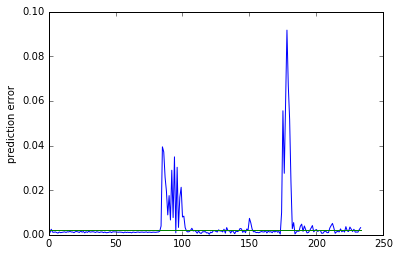

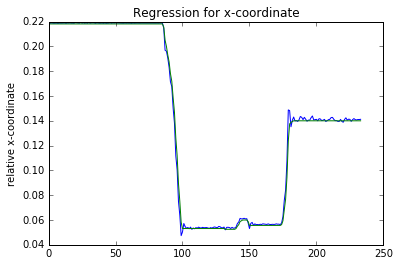

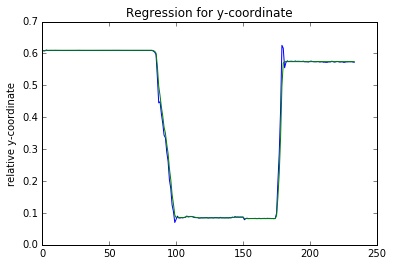

MSE per 0.03s: 9.87222856249e-05
MSE per pixel move: 0.0213276017827
number of records: 234

max - |x+y|: 0.0755707077056
max - squared: 0.00571093186312
smoothed MSE: 7.38659538538e-07
smoothed MSE per dist: 0.00214136916851
This is not Felix - You are unauthorized!


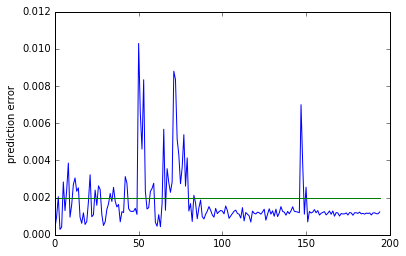

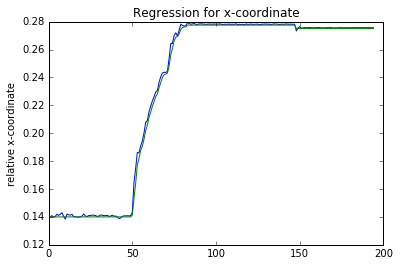

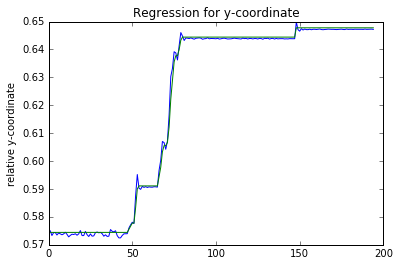

MSE per 0.03s: 3.11105855885e-06
MSE per pixel move: 0.00352509629264
number of records: 195

max - |x+y|: 0.00997835024606
max - squared: 9.9567473633e-05
smoothed MSE: 6.71350597139e-07
smoothed MSE per dist: 0.00433136384525
This is not Felix - You are unauthorized!


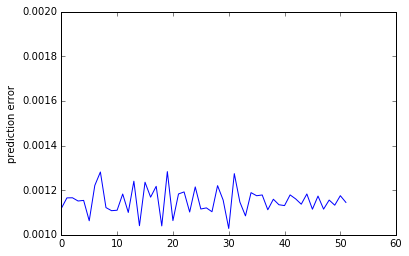

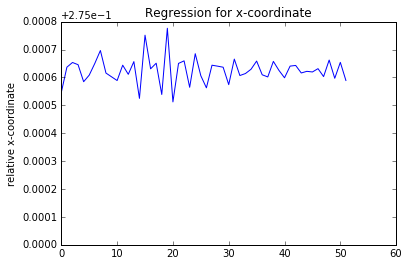

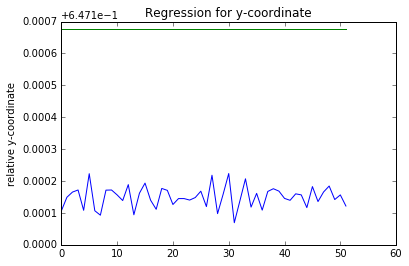

MSE per 0.03s: 6.72087449513e-07
MSE per pixel move: inf
number of records: 52

max - |x+y|: 0.000776088412188
max - squared: 6.02313223532e-07
smoothed MSE: 6.72087449513e-07
smoothed MSE per dist: 0.0
This is not Felix - You are unauthorized!


/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:47: RuntimeWarning: divide by zero encountered in double_scalars


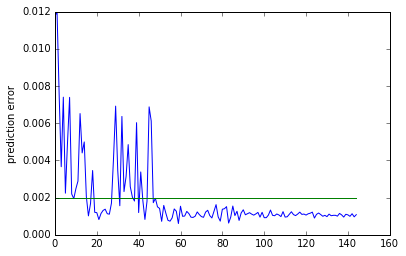

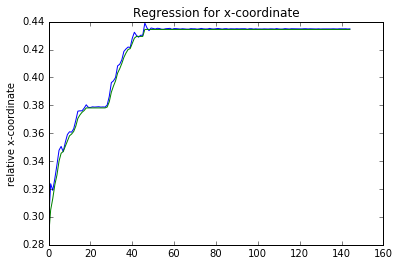

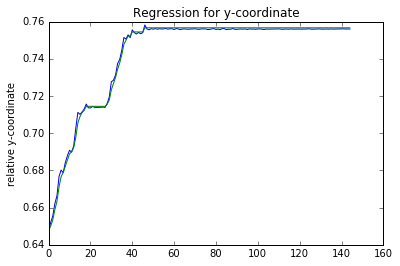

MSE per 0.03s: 4.46485303095e-06
MSE per pixel move: 0.0037778080821
number of records: 145

max - |x+y|: 0.0106390199539
max - squared: 0.00011318874558
smoothed MSE: 6.81893666935e-07
smoothed MSE per dist: 0.0432186321504
This is not Felix - You are unauthorized!


In [22]:
(data, target) = extractFeatures(resource_path + "unauthorized/martin_60sec", 
                                 n_last_timestamps_as_features=current_number_features)

for i in range(data.shape[0] / test_size):
    fileX = data[(i*test_size):((i+1)*test_size),:]
    fileY = target[(i*test_size):((i+1)*test_size),:]

    showStatsData((fileX, fileY), model, two_sigma, n_last_timestamps_as_features=current_number_features)

In [25]:
#(data, target) = extractFeatures(resource_path + "felix/felix_1h", n_last_timestamps_as_features=current_number_features)
(data, target) = extractFeatures(resource_path + "felix/felix_2h", n_last_timestamps_as_features=current_number_features)
                                 
Ni = data.shape[0]
    
X_test = data[(Ni/2):Ni,:]
y_test = target[(Ni/2):Ni,:]

c1 = 0

time_array = {}
dist_array = {}

print data.shape

print (data.shape[0] / test_size)

for i in range(X_test.shape[0] / test_size):
    fileX = X_test[(i*test_size):((i+1)*test_size),:]
    fileY = y_test[(i*test_size):((i+1)*test_size),:]    
    
    (time_array[i], dist_array[i], N_smoothed, classification_show) = showStatsData((fileX, fileY), model, two_sigma, n_last_timestamps_as_features = current_number_features, v = False)  
    
    if (N_smoothed > 40):
        
        if (time_array[i] > theta):
            c1 += 1
            print ("error: " + str(time_array[i]) + " N: " + str(N_smoothed))
                
                
    
        
print("bad count - time measure: " + str(c1) + " of " + str(X_test.shape[0] / test_size))

print("\nmax time_error: " + str(np.max(time_array.values())) )

mean difference in time step: 0.030002375188
original shape: (239882, 200)
(239882, 201)
1025
error: 3.84414973511e-07 N: 52
error: 4.4265057382e-07 N: 113
error: 4.50988272836e-07 N: 166
error: 4.83386843287e-07 N: 129
error: 4.63175544438e-07 N: 181
error: 4.46951139751e-07 N: 155
error: 4.23034126306e-07 N: 87
error: 5.9863415762e-07 N: 77
error: 4.67854219894e-07 N: 135
error: 6.54206047465e-07 N: 131
error: 5.52336339758e-07 N: 101
error: 6.94914349561e-07 N: 89
error: 5.73309471585e-07 N: 79
error: 4.95491575438e-07 N: 61
error: 6.54028257684e-07 N: 75
error: 4.22735290936e-07 N: 153
error: 3.98197526791e-07 N: 49
error: 3.63648276955e-07 N: 51
error: 4.26405588983e-07 N: 95
error: 3.78693456313e-07 N: 116
error: 3.73090048747e-07 N: 56
error: 4.69144727887e-07 N: 93
error: 4.90545611717e-07 N: 127
error: 3.8345570582e-07 N: 133
error: 3.88123781838e-07 N: 101
error: 5.28842438886e-07 N: 83
error: 4.69719993632e-07 N: 58
error: 5.89250903658e-07 N: 99
error: 3.57499669356e-07 N: 